<a href="https://www.kaggle.com/code/aleksandrmorozov123/machine-learning-excercises?scriptVersionId=93950211" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


**Import required libraries**

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import (
    ensemble, 
    preprocessing, 
    tree,
)
from sklearn.metrics import (
auc,
confusion_matrix,
roc_auc_score,
roc_curve
)
from sklearn.model_selection import (
train_test_split,
)
from yellowbrick.classifier import (
ConfusionMatrix,
ROCAUC,
)
from yellowbrick.model_selection import (
LearningCurve,
)

**Read the data Titanic dataset**

In [3]:
df = pd.read_csv ('../input/titanic/train.csv')
orig_df = df

df.head (10)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   
7                     Palsson, Master. Gosta Leonard    male   2.0      3   
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
5      0            330877   8.4583   NaN        Q  
6      0             17463  51.8625   E46        S  
7      1            349909  21.0750   NaN        S  
8      2            347742  11.1333   NaN        S  
9      0            237736  30.0708   NaN        C

**Cleaning the data**

In [4]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
import pandas_profiling
pandas_profiling.ProfileReport (df)

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
df.shape

(891, 12)

In [7]:
df.describe ().iloc[:, :2]

PassengerId    Survived
count   891.000000  891.000000
mean    446.000000    0.383838
std     257.353842    0.486592
min       1.000000    0.000000
25%     223.500000    0.000000
50%     446.000000    0.000000
75%     668.500000    1.000000
max     891.000000    1.000000

In [8]:
df.isnull ().sum ()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
df.isnull ().sum (axis = 1).loc[:10]

0     1
1     0
2     1
3     0
4     1
5     2
6     0
7     1
8     1
9     1
10    0
dtype: int64

In [10]:
mask = df.isnull ().any (axis = 1)
mask.head ()  # rows

0     True
1    False
2     True
3    False
4     True
dtype: bool

In [11]:
df [mask].Embarked.head ()

0    S
2    S
4    S
5    Q
7    S
Name: Embarked, dtype: object

In [12]:
df.Sex.value_counts (dropna = False)

male      577
female    314
Name: Sex, dtype: int64

In [13]:
df.Embarked.value_counts (dropna = False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [14]:
df = df.drop (
     columns = [
         "Name",
         "Ticket",
         "Fare",
         "Cabin"
])
df = pd.get_dummies (df)
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

**Sample data**

In [15]:
from sklearn.model_selection import train_test_split
y = df.Survived
X = df.drop (columns = "Survived")

**Impute data**

In [16]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state = 42)

from sklearn.experimental import enable_iterative_imputer
from sklearn import impute
num_cols = ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

imputer = impute.IterativeImputer ()
imputed = imputer.fit_transform (
X_train [num_cols])
X_train.loc [:, num_cols] = imputed

meds = X_train.median ()
X_train = X_train.fillna (meds)
X_test = X_test.fillna (meds)

**Normalize data**

In [17]:
cols = "'PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch','Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'".split (",")
sca = preprocessing.StandardScaler ()
X_train = sca.fit_transform (X_train)
X_train = pd.DataFrame (X_train, columns = cols)
X_test = sca.transform (X_test)
X_test = pd.DataFrame (X_test, columns = cols)

**Refactor**

In [18]:
from sklearn.model_selection import train_test_split
def tweak_titanic (df):
    df = df.drop (
    columns = [
        "PassengerId",
        "Name",
        "Sex",
        "Age",
        "Ticket",
        "Fare",
        "Cabin",
    ]
    ).pipe (pd.get_dummies, drop_first = True)
    return df

def get_train_test_X_y (
df, y_col, size = 0.3, std_cols = None
):
    y = df [y_col]
    X = df.drop (columns = y_col)
    X_train, X_test, y_train, y_test = train_test_split (
    X, y, test_size = size, random_state = 42
    )
    cols = X.columns
    num_cols = ['Pclass', 'SibSp', 'Parch',
    'Embarked_Q', 'Embarked_S']
    fi = impute.IterativeImputer ()
    X_train.loc [
        :, num_cols
    ] = fi.fit_transform (X_train [num_cols])
    X_test.loc [:, num_cols] = fi.transform (
    X_test [num_cols])
    
    if std_cols:
        std = preprocessing.StandardScaler ()
        X_train.loc [
            :, std_cols
        ] = std.fit_transform (
        X_train [std_cols])
        
        X_test.loc [
            :, std_cols
        ] = std.transform (X_test [std_cols])
        return X_train, X_test, y_train, y_test
    
ti_df = tweak_titanic (orig_df)
std_cols = "Pclass".split (",")
X_train, X_test, y_train, y_test = get_train_test_X_y (ti_df, "Survived", std_cols = std_cols)

**Baseline model**

In [19]:
from sklearn.dummy import DummyClassifier
bm = DummyClassifier ()
bm.fit (X_train, y_train)
bm.score (X_test, y_test) # accuracy

0.585820895522388

In [20]:
from sklearn import metrics
metrics.precision_score (y_test, bm.predict (X_test))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

**K-fold cross-validation**

In [21]:
X = pd.concat ([X_train, X_test])
y = pd.concat ([y_train, y_test])
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

for model in [
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier, 
    GaussianNB,
    SVC,
    RandomForestClassifier,
    ]:
    cls = model ()
    kfold = model_selection.KFold (n_splits=10, random_state=None)
    s = model_selection.cross_val_score (
    cls, X, y, scoring = 'roc_auc', cv = kfold)

    print (f"{model.__name__:22}   AUC: "
          f"{s.mean (): .3f} STD: {s.std(): .2f}")

DummyClassifier          AUC:  0.500 STD:  0.00
LogisticRegression       AUC:  0.717 STD:  0.05
DecisionTreeClassifier   AUC:  0.727 STD:  0.05
KNeighborsClassifier     AUC:  0.715 STD:  0.04
GaussianNB               AUC:  0.693 STD:  0.03
SVC                      AUC:  0.713 STD:  0.03
RandomForestClassifier   AUC:  0.734 STD:  0.05


**Staking**

In [22]:
from mlxtend.classifier import StackingClassifier
clfs = [
    x()
    for x in [
        LogisticRegression,
        DecisionTreeClassifier,
        GaussianNB,
        SVC,
        RandomForestClassifier
    ]
]
stack = StackingClassifier (classifiers=clfs,
                          meta_classifier = LogisticRegression ())
kfold = model_selection.KFold (n_splits = 10, random_state = None)

s = model_selection.cross_val_score (stack, X, y, scoring = 'roc_auc', cv = kfold)

print (f"{stack.__class__.__name__}  "
      f"AUC: {s.mean():.3f}  STD: {s.std():.2f}")

StackingClassifier  AUC: 0.690  STD: 0.04


**Create and evaluate Model**

In [23]:
# create model
rf = ensemble.RandomForestClassifier (n_estimators = 100, random_state = 42)
rf.fit (X_train, y_train)

# evaluate model
rf.score (X_test, y_test)

0.6940298507462687

In [24]:
# metrics precision
metrics.precision_score (y_test, rf.predict (X_test))

0.6790123456790124

In [25]:
# inspect feature performance
for col, val in sorted (zip (X_train.columns, rf.feature_importances_),
                       key = lambda x: x[1], reverse = True,
                       )[:5]:
    print (f"{col:10}{val:10.3f}")

Pclass         0.353
Parch          0.243
SibSp          0.238
Embarked_S     0.120
Embarked_Q     0.046


**Optimize model**

In [26]:
rf4 = ensemble.RandomForestClassifier ()
params = {
    "max_features": [0.4, "auto"],
    "n_estimators": [15, 200],
    "min_samples_leaf": [1, 0.1],
    "random_state": [42],
}
cv = model_selection.GridSearchCV (rf4, params, n_jobs=-1
                                  ).fit(X_train, y_train)
print (cv.best_params_)

{'max_features': 0.4, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 42}


In [27]:
rf5 = ensemble.RandomForestClassifier (
**{
    "max_features": "auto",
    "min_samples_leaf": 0.1,
    "n_estimators": 200,
    "random_state": 42,
})
rf5.fit (X_train, y_train)

rf5.score (X_test, y_test)

0.6492537313432836

**Confusion matrix**

In [28]:
from sklearn.metrics import confusion_matrix
y_pred = rf5.predict (X_test)
confusion_matrix (y_test, y_pred)

array([[145,  12],
       [ 82,  29]])

/opt/conda/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


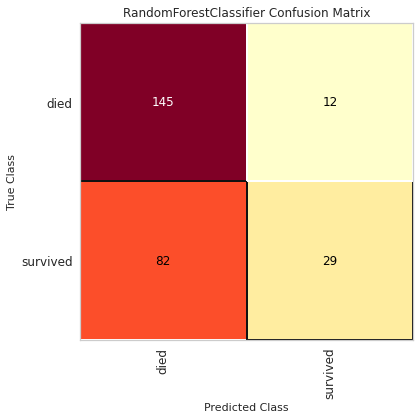

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [29]:
mapping = {0: "died", 1: "survived"}
fig, ax = plt.subplots (figsize = (6, 6))
cm_viz = ConfusionMatrix (rf5, classes = ["died", "survived"],
                         label_encoder = mapping)
cm_viz.score (X_test, y_test)
cm_viz.poof ()

**ROC Curve**

In [30]:
y_pred = rf5.predict (X_test)
roc_auc_score (y_test, y_pred)

0.5924140701210765

/opt/conda/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


AttributeError: 'RandomForestClassifier' object has no attribute 'target_type_'

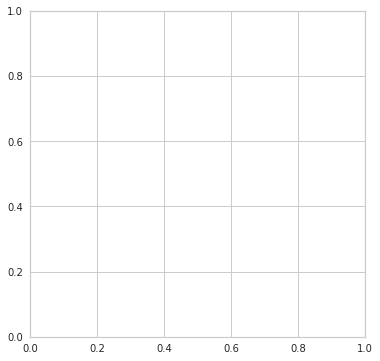

In [31]:
from yellowbrick.classifier import ConfusionMatrix, ROCAUC
fig, ax = plt.subplots (figsize = (6, 6))
roc_viz = ROCAUC (rf5)
roc_viz.score (X_test, y_test)
roc_viz.poof ()

**Learning curve**

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

fig, ax = plt.subplots (figsize = (6, 4))
cv = StratifiedKFold (12)
sizes = np.linspace (0.3, 1.0, 10)
lc_viz = LearningCurve (
rf5, 
cv = cv,
train_sizes = sizes,
scoring = "f1_weighted",
n_jobs = 4,
ax = ax)

lc_viz.fit (X, y)
lc_viz.poof ()

**Deploing model**

In [ ]:
import pickle
pic = pickle.dumps (rf5)
rf6 = pickle.loads (pic)
y_pred = rf6.predict (X_test)
roc_auc_score (y_test, y_pred)

# **The model did not show the most optimal result, so let's start all over again and carefully work through each step of titanic dataset**

**Examining missing data**

In [ ]:
df.isnull ().mean () * 100

**Using missingno library**

In [ ]:
import missingno as msno
ax = msno.matrix (orig_df.sample (500))

**Bar plot**

In [ ]:
fig, ax = plt.subplots (figsize = (6, 4))
(df.isnull().mean().abs().plot.bar (ax=ax))

**Missingno library bar plot**

In [ ]:
ax = msno.bar (orig_df.sample (500))

**Create a heatmap**

In [ ]:
ax = msno.heatmap (df, figsize = (6, 6))

**Create a dendrogram**

In [ ]:
ax = msno.dendrogram (df)

**Dropping missnig data**

In [ ]:
df1 = df.dropna ()
df1 = df.drop (columns = "Cabin")
df1 = df.dropna (axis = 1)

**Imputing data**

In [ ]:
from sklearn.impute import SimpleImputer 
num_cols = df.select_dtypes (include = "number").columns
im = SimpleImputer ()  # mean
imputed = im.fit_transform (df[num_cols])

**Adding indicator columns**

In [ ]:
def add_indicator (col):
    def wrapper (df):
        return df[col].isna().astype (int)
    
    return wrapper

df1 = df.assign (cabin_missing = add_indicator ("Cabin"))

**Exploring data**

In [ ]:
df.shape 

In [ ]:
df.describe ().iloc [:, [0, -1]]

In [ ]:
df.iloc [[1, 4], -3:]

In [ ]:
df.loc [[101, 417], "Embarked":]

In [ ]:
df.head (5)

**Histogram**

In [ ]:
fig, ax = plt.subplots (figsize = (6, 4))
df.Fare.plot (kind ="hist", ax=ax)

In [ ]:
import seaborn as sns
fig, ax = plt.subplots (figsize = (12, 8))
mask = y_train == 1
ax = sns.histplot (X_train [mask].Parch, label = 'Survived')
ax = sns.histplot (X_train [~mask].Parch, label = 'Died')
ax.set_xlim(-1.5, 1.5)
ax.legend ()

**Scatter plot**

In [ ]:
fig, ax = plt.subplots (figsize= (6, 4))
df.plot.scatter (x = "Age", y = "Fare", ax = ax, alpha = 0.3)

In [ ]:
df.Parch.corr (df.Age)

**Joint plot**

In [ ]:
from yellowbrick.features import JointPlotVisualizer

fig, ax = plt.subplots (figsize = (6, 6))
jpv = JointPlotVisualizer (feature = "Pclass", target = "SibSp")
jpv.fit (df["Pclass"], df["SibSp"])
jpv.poof ()

In [ ]:
# use seaborn library to create a joint plot
from seaborn import jointplot
fig, ax = plt.subplots (figsize = (6, 6))
new_df = df.copy ()
new_df = df.copy ()
new_df["target"] = y
p = jointplot ("Pclass", "Parch", data = new_df, kind = "reg")

**Pair grid**

In [ ]:
from seaborn import pairplot
fig, ax = plt.subplots(figsize = (6, 6))
new_df = df.copy ()
new_df ["target"] = y
vars = ["Pclass", "Fare", "Age"]
p = pairplot (new_df, vars = vars, hue = "target", kind = "reg")

**Box and violin plots**

In [ ]:
from seaborn import boxplot
fig, ax = plt.subplots (figsize = (8, 6))
new_df = df.copy ()
new_df ["target"] = y
boxplot (x = "target", y = "Age", data= new_df)

In [ ]:
from seaborn import violinplot
fig, ax= plt.subplots (figsize = (8, 6))
new_df = df.copy ()
new_df ["target"] = y
violinplot (x = "target", y = "Age", data = new_df)

**Comparing two ordinal values**

In [ ]:
fig, ax = plt.subplots (figsize = (8, 6))
(df.assign (age_bin = pd.qcut (df.Age, q = 10, labels = False),
          class_bin = pd.cut (df.Pclass, bins = 3, labels = False),
          ).pipe (lambda df: pd.crosstab (df.age_bin, df.class_bin))
 .pipe (lambda df: df.div (df.sum (1), axis = 0))
 .plot.bar (stacked = True,
           width = 1,
           ax = ax,
           cmap = 'viridis',
           )
 .legend (bbox_to_anchor = (1, 1)))

**Correlation**

In [ ]:
from yellowbrick.features import Rank2D
fig, ax = plt.subplots (figsize = (6, 6))
pcv = Rank2D (features = X.columns, algorithm = "pearson")
pcv.fit (X, y)
pcv.transform (X)
pcv.poof ()

In [ ]:
from seaborn import heatmap
fig, ax = plt.subplots (figsize = (8, 8))
ax = heatmap (
X.corr (),
fmt = ".2f",
annot = True,
ax = ax,
cmap = "RdBu_r",
vmin = -1,
vmax = 1)

In [ ]:
df.corr ().iloc [:, :2]

In [ ]:
def correlated_columns (df, threshold = 0.95):
    return (df.corr ().pipe (
    lambda df1: pd.DataFrame (np.tril (df1, k=-1),
                             columns = df.columns,
                             index = df.columns)).stack ()
           .rename ("pearson").pipe (lambda s: s [
               s.abs () > threshold].reset_index ())
           .query ("level_0 not in level_1"))

correlated_columns (X)

**RadViz**

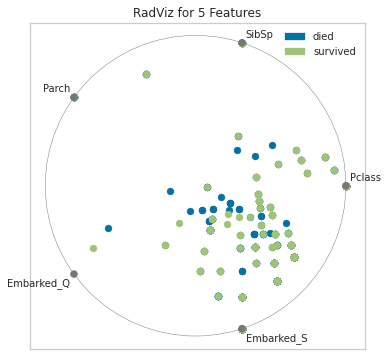

<AxesSubplot:title={'center':'RadViz for 5 Features'}>

In [39]:
from yellowbrick.features import RadViz
fig, ax = plt.subplots (figsize = (6, 6))
rv = RadViz (classes = ["died", "survived"],
            features = X.columns)
rv.fit (X, y)
_ = rv.transform (X)
rv.poof ()

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:178: RuntimeWarning: invalid value encountered in true_divide
  y = (s * row_).sum(axis=0) / row.sum()


<AxesSubplot:>

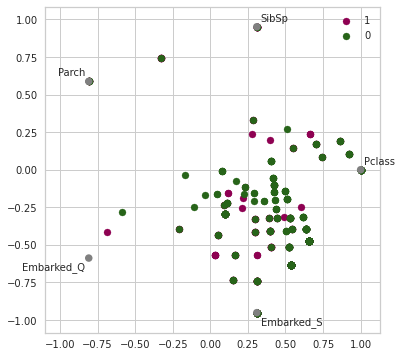

In [40]:
# pandas library can plot RadViz
from pandas.plotting import radviz
fig, ax = plt.subplots (figsize = (6, 6))
new_df = X.copy ()
new_df ["target"] = y
radviz (new_df, "target", ax = ax, colormap = "PiYG")

**Parallel coordinates**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


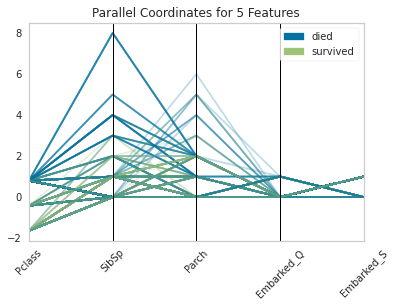

<AxesSubplot:title={'center':'Parallel Coordinates for 5 Features'}>

In [34]:
from yellowbrick.features import ParallelCoordinates
fig, ax = plt.subplots (figsize = (6, 4))
pc = ParallelCoordinates (classes = ["died", "survived"],
                         features = X.columns)
pc.fit (X, y)
pc.transform (X)
ax.set_xticklabels (ax.get_xticklabels (), rotation = 45)
pc.poof ()

[Text(0, 0, 'Pclass'),
 Text(1, 0, 'SibSp'),
 Text(2, 0, 'Parch'),
 Text(3, 0, 'Embarked_Q'),
 Text(4, 0, 'Embarked_S')]

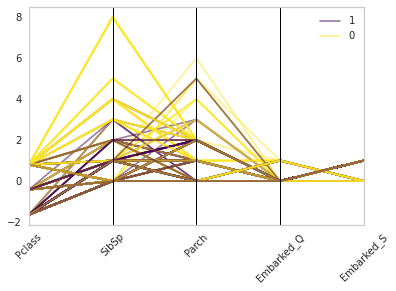

In [41]:
# pandas library can plot parallel coordinates
from pandas.plotting import parallel_coordinates
fig, ax = plt.subplots (figsize = (6, 4))
new_df = X.copy ()
new_df ["target"] = y
parallel_coordinates (new_df, "target", ax = ax, colormap = "viridis", alpha = 0.5)
ax.set_xticklabels (ax.get_xticklabels (), rotation = 45)

**Standardize data**

In [47]:
from sklearn import preprocessing
X2 = df
std = preprocessing.StandardScaler ()
std.fit_transform (X)

array([[-1.56610693, -0.4745452 ,  2.00893337, -0.30756234,  0.61930636],
       [ 0.82737724, -0.4745452 , -0.47367361, -0.30756234,  0.61930636],
       [ 0.82737724,  0.43279337,  0.76762988, -0.30756234,  0.61930636],
       ...,
       [-1.56610693, -0.4745452 , -0.47367361, -0.30756234,  0.61930636],
       [ 0.82737724, -0.4745452 , -0.47367361, -0.30756234,  0.61930636],
       [-1.56610693, -0.4745452 , -0.47367361, -0.30756234,  0.61930636]])

In [48]:
std.scale_

array([1.01991414, 1.10212444, 0.80560476, 0.28098288, 0.44762435])

In [49]:
std.mean_

array([-0.04058664,  0.52300786,  0.38159371,  0.08641975,  0.72278339])

In [50]:
std.var_

array([1.04022486, 1.21467827, 0.64899903, 0.07895138, 0.20036756])

In [51]:
X_std = (X2 - X2.mean ()) / X2.std ()
X_std

PassengerId  Survived    Pclass       Age     SibSp     Parch  \
0      -1.729137 -0.788829  0.826913 -0.530005  0.432550 -0.473408   
1      -1.725251  1.266279 -1.565228  0.571430  0.432550 -0.473408   
2      -1.721365  1.266279  0.826913 -0.254646 -0.474279 -0.473408   
3      -1.717480  1.266279 -1.565228  0.364911  0.432550 -0.473408   
4      -1.713594 -0.788829  0.826913  0.364911 -0.474279 -0.473408   
..           ...       ...       ...       ...       ...       ...   
886     1.713594 -0.788829 -0.369158 -0.185807 -0.474279 -0.473408   
887     1.717480  1.266279 -1.565228 -0.736524 -0.474279 -0.473408   
888     1.721365 -0.788829  0.826913       NaN  0.432550  2.007806   
889     1.725251  1.266279 -1.565228 -0.254646 -0.474279 -0.473408   
890     1.729137 -0.788829  0.826913  0.158392 -0.474279 -0.473408   

     Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0     -0.737281  0.737281   -0.481772   -0.307390    0.618959  
1      1.354813 -1.354813    2.073341   -0.307390   -1.613803  
2      1.354813 -1.354813   -0.481772   -0.307390    0.618959  
3      1.354813 -1.354813   -0.481772   -0.307390    0.618959  
4     -0.737281  0.737281   -0.481772   -0.307390    0.618959  
..          ...       ...         ...         ...         ...  
886   -0.737281  0.737281   -0.481772   -0.307390    0.618959  
887    1.354813 -1.354813   -0.481772   -0.307390    0.618959  
888    1.354813 -1.354813   -0.481772   -0.307390    0.618959  
889   -0.737281  0.737281    2.073341   -0.307390   -1.613803  
890   -0.737281  0.737281   -0.481772    3.249548   -1.613803  

[891 rows x 11 columns]

In [52]:
X_std.mean ()

PassengerId   -2.317637e-17
Survived       1.788070e-16
Pclass         1.679664e-16
Age            2.003921e-16
SibSp          2.108302e-16
Parch         -3.638441e-17
Sex_female     3.528790e-16
Sex_male      -4.273923e-16
Embarked_C     1.209283e-16
Embarked_Q     2.811070e-16
Embarked_S    -2.930690e-16
dtype: float64

In [53]:
X_std.std ()

PassengerId    1.0
Survived       1.0
Pclass         1.0
Age            1.0
SibSp          1.0
Parch          1.0
Sex_female     1.0
Sex_male       1.0
Embarked_C     1.0
Embarked_Q     1.0
Embarked_S     1.0
dtype: float64

**Scale to range**

In [59]:
from sklearn import preprocessing
mms = preprocessing.MinMaxScaler ()
mms.fit (X2)
mms.transform (X2)

array([[0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.0011236 , 1.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.00224719, 1.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.99775281, 0.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.9988764 , 1.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ]])

In [60]:
# pandas preprocessing
(X2 - X2.min ()) / (X2.max () - X2.min ())

PassengerId  Survived  Pclass       Age  SibSp     Parch  Sex_female  \
0       0.000000       0.0     1.0  0.271174  0.125  0.000000         0.0   
1       0.001124       1.0     0.0  0.472229  0.125  0.000000         1.0   
2       0.002247       1.0     1.0  0.321438  0.000  0.000000         1.0   
3       0.003371       1.0     0.0  0.434531  0.125  0.000000         1.0   
4       0.004494       0.0     1.0  0.434531  0.000  0.000000         0.0   
..           ...       ...     ...       ...    ...       ...         ...   
886     0.995506       0.0     0.5  0.334004  0.000  0.000000         0.0   
887     0.996629       1.0     0.0  0.233476  0.000  0.000000         1.0   
888     0.997753       0.0     1.0       NaN  0.125  0.333333         1.0   
889     0.998876       1.0     0.0  0.321438  0.000  0.000000         0.0   
890     1.000000       0.0     1.0  0.396833  0.000  0.000000         0.0   

     Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0         1.0         0.0         0.0         1.0  
1         0.0         1.0         0.0         0.0  
2         0.0         0.0         0.0         1.0  
3         0.0         0.0         0.0         1.0  
4         1.0         0.0         0.0         1.0  
..        ...         ...         ...         ...  
886       1.0         0.0         0.0         1.0  
887       0.0         0.0         0.0         1.0  
888       0.0         0.0         0.0         1.0  
889       1.0         1.0         0.0         0.0  
890       1.0         0.0         1.0         0.0  

[891 rows x 11 columns]

**Dummy variables**

In [61]:
pd.get_dummies (df, drop_first = True)

PassengerId  Survived  Pclass   Age  SibSp  Parch  Sex_female  Sex_male  \
0              1         0       3  22.0      1      0           0         1   
1              2         1       1  38.0      1      0           1         0   
2              3         1       3  26.0      0      0           1         0   
3              4         1       1  35.0      1      0           1         0   
4              5         0       3  35.0      0      0           0         1   
..           ...       ...     ...   ...    ...    ...         ...       ...   
886          887         0       2  27.0      0      0           0         1   
887          888         1       1  19.0      0      0           1         0   
888          889         0       3   NaN      1      2           1         0   
889          890         1       1  26.0      0      0           0         1   
890          891         0       3  32.0      0      0           0         1   

     Embarked_C  Embarked_Q  Embarked_S  
0             0           0           1  
1             1           0           0  
2             0           0           1  
3             0           0           1  
4             0           0           1  
..          ...         ...         ...  
886           0           0           1  
887           0           0           1  
888           0           0           1  
889           1           0           0  
890           0           1           0  

[891 rows x 11 columns]

**Label encoder**

In [69]:
df1 = pd.read_csv ('../input/titanic/train.csv')
df1.head (5)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [71]:
from sklearn import preprocessing
lab = preprocessing.LabelEncoder ()
lab.fit_transform (df1.Name)

array([108, 190, 353, 272,  15, 554, 515, 624, 412, 576, 727,  95, 729,
        28, 840, 359, 682, 867, 839, 512, 273,  80, 523, 765, 626,  44,
       240, 260, 605, 813, 828, 776, 289, 856, 535, 372, 505, 134, 837,
       589,   7, 827, 446, 456, 212, 697, 473, 604, 726,  38, 629, 594,
       333, 246, 620, 873, 707, 595, 853, 299, 749, 385, 337, 755, 784,
       560, 596, 185,  25, 440, 396, 300, 376, 161,  87, 546, 778, 563,
       127, 223, 842, 737, 519, 141, 386,  52, 255, 764, 259, 149, 159,
        31, 150, 209, 184, 740, 292, 308, 219, 422, 656, 658, 858, 405,
       312, 542, 724, 559, 675, 552, 667, 882,  67, 417,  46, 645, 178,
       826,  70,  24, 362, 551, 575, 848, 857, 588, 525, 499, 653, 234,
       225, 165, 695, 851, 772, 685, 585, 271, 618, 282,  99, 597, 319,
       116,  32, 586,  29, 254, 580, 121,  68, 643, 532, 889, 612, 866,
       287, 181, 767, 716, 186, 847,  82, 129, 628, 293, 157, 760,  69,
       486, 832, 680, 408, 752, 769, 444, 464, 388, 320, 474, 71

In [72]:
lab.inverse_transform ([1, 1, 0])

array(['Abbott, Mr. Rossmore Edward', 'Abbott, Mr. Rossmore Edward',
       'Abbing, Mr. Anthony'], dtype=object)